<a href="https://colab.research.google.com/github/GabrielChuchuca/SIMULACION/blob/main/DeberSimPySEDLavanderiaUPS_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practica 2 - SimPy SED ##
Modifique el código anterior a fin de incorporar los siguientes cambios:

- Considerar 3 tipos de vehículos con 3 diferentes tiempos de lavado:
    - Bus: 20 minutos
    - Automóvil: 7 minutos
    - Furgoneta: 12 minutos
- Considere que a partir de la entrada del vehículo para ser lavado, deberán tomarse en cuenta los siguientes tiempos correspondientes al proceso de traslado desde la recepción a la máquina de lavado:
    - Bus: 4 minutos
    - Automóvil: 1 minuto
    - Furgoneta: 2 minutos
- Realice una gráfica comparativa de la simulación con 3 y con 4 máquinas de lavado

#  MAQUINAS #

In [ ]:
# pip install simpy
import simpy
import random
import matplotlib.pyplot as plt
# Maximo de vehiculos que puede recibir el negocio
MAX_VEHICULOS = 57 
# Total de maquinas de lavado con que cuenta el negocio
NUM_MAQUINAS = 3
#Tiempo de traslado de vehiculos
TRASLADO= [4,1,2]
# Tiempo que tarda en lavarse un vehiculo (minutos)
#Bus: 20min, Automóvil: 7min, Furgoneta: 12min
TIEMPO_LAVADO =[20,7,12] #7 
# Intervalo de tiempo en que llegan vehiculos (minutos)
# Bus: 4min, Automóvil: 1 min, Furgoneta: 2 min.
INTERVALO_LLEGADA = 10
# Tiempo de simulación
TIEMPO_SIMULACION = 100

tiempo= {}

In [ ]:
class LavanderiaUPS(object):
    def __init__(self, environment, num_maquinas,tiempo_bus,tiempo_automovil,
                 tiempo_furgoneta,traslado_bus,traslado_automovil,traslado_furgoneta):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.maquinas = simpy.Resource(environment, num_maquinas)
        # Variable para el tiempo de lavado
        self.tiempo_bus = tiempo_bus
        self.tiempo_automovil = tiempo_automovil
        self.tiempo_furgoneta = tiempo_furgoneta
        self.traslado_bus = traslado_bus
        self.traslado_automovil = traslado_automovil
        self.traslado_furgoneta = traslado_furgoneta
        
    def lavado(self, vehiculo):
        automotor=vehiculo.split('-')
        if(automotor[0] == 'Bus'):
            yield self.env.timeout(TRASLADO[0])
        if(automotor[0] == 'Automovil'):
            yield self.env.timeout(TRASLADO[1])
        if(automotor[0] == 'Furgoneta'):
            yield self.env.timeout(TRASLADO[2])
        #Solo agregamos al diccionario al momento que termina de lavar el vehiculo.
        k=automotor[0]
        if k in tiempo:
            tiempo[k]=tiempo[k]+1
        else:
            tiempo[k]=1
            
        # Simulamos que se ha limpiado parte (%) de la suciedad del vehiculo
        # Para el % generamos un entero entre 30 y 90
        print('Removido  {%d%%} suciedad vehiculo => %s ' %(random.randint(30,90), vehiculo))
        
    def traslado(self, vehiculo):
        automotor=vehiculo.split('-')
        if(automotor[0] == 'Bus'):
            yield self.env.timeout(TRASLADO[0])
        if(automotor[0] == 'Automovil'):
            yield self.env.timeout(TRASLADO[1])
        if(automotor[0] == 'Furgoneta'):
            yield self.env.timeout(TRASLADO[2])

In [ ]:
def llegada(env, nombre, lavanderiaups):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el vehiculo con el nombre pasado como parametro
    print('Llega vehiculo: %s a la hora %.2f.' % (nombre, env.now))
    
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la maquina de lavado
    with lavanderiaups.maquinas.request() as maquina:
        # Ocupamos la maquina de lavado
        yield maquina
        #Indicamos que el vehiculo se esta trasladando para ser lavado
        print('Se traslada vehiculo: %s a la hora %.2f.' % (nombre,env.now))
        #Procesamos el traslado del vehiculo
        yield env.process(lavanderiaups.traslado(nombre))
        # Indicamos que vehiculo entra a la lavanderia
        print('Entra vehiculo a lavarse: %s a la hora %.2f.' % (nombre, env.now))
        # Procesamos la operacion de lavado
        yield env.process(lavanderiaups.lavado(nombre))
        # Una vez que termina la llamada con 'yield', se indica que se ha lavado el vehiculo
        print('Vehiculo [%s] lavado a las %.2f.' % (nombre, env.now))  

In [ ]:
def ejecucion(env, num_maquinas, tiempo_bus, tiempo_automovil, tiempo_furgoneta, traslado_bus, traslado_automovil, traslado_furgoneta, intervalo):
    lavanderiaups=LavanderiaUPS(env, num_maquinas, tiempo_bus, tiempo_automovil, tiempo_furgoneta, traslado_bus, traslado_automovil, traslado_furgoneta)
    # Creamos 5 llegadas de vehiculos iniciales
    for i in range(2):
        env.process(llegada(env, 'Bus-%d'%(i+1),lavanderiaups))
        env.process(llegada(env, 'Automovil-%d'%(i+1),lavanderiaups))
        env.process(llegada(env, 'Furgoneta-%d'%(i+1),lavanderiaups))
        
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(random.randint(intervalo-3, intervalo+3))
        i+=1
        # Mientras se lavan los vehiculos generamos mas vehiculos
        rnd = random.randint(1,100)
        if rnd <= 20: # Bus 20%, Furgoneta 30% y Automovil 50%
            env.process(llegada(env,'Bus-%d'%(i+1),lavanderiaups))
        elif rnd <= 50:
            env.process(llegada(env,'Furgoneta-%d'%(i+1),lavanderiaups))
        else:
            env.process(llegada(env,'Automovil-%d'%(i+1),lavanderiaups))

In [ ]:
print('Lavanderia UPS')
# Inicializamos la semilla aleatoria
random.seed(77)

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecucion(env, NUM_MAQUINAS, TIEMPO_LAVADO[0], TIEMPO_LAVADO[1], TIEMPO_LAVADO[2], TRASLADO[0], TRASLADO[1], TRASLADO[2], INTERVALO_LLEGADA))

# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

Lavanderia UPS
Llega vehiculo: Bus-1 a la hora 0.00.
Llega vehiculo: Automovil-1 a la hora 0.00.
Llega vehiculo: Furgoneta-1 a la hora 0.00.
Llega vehiculo: Bus-2 a la hora 0.00.
Llega vehiculo: Automovil-2 a la hora 0.00.
Llega vehiculo: Furgoneta-2 a la hora 0.00.
Se traslada vehiculo: Bus-1 a la hora 0.00.
Se traslada vehiculo: Automovil-1 a la hora 0.00.
Se traslada vehiculo: Furgoneta-1 a la hora 0.00.
Entra vehiculo a lavarse: Automovil-1 a la hora 1.00.
Removido  {46%} suciedad vehiculo => Automovil-1 
Entra vehiculo a lavarse: Furgoneta-1 a la hora 2.00.
Vehiculo [Automovil-1] lavado a las 2.00.
Se traslada vehiculo: Bus-2 a la hora 2.00.
Removido  {50%} suciedad vehiculo => Furgoneta-1 
Entra vehiculo a lavarse: Bus-1 a la hora 4.00.
Vehiculo [Furgoneta-1] lavado a las 4.00.
Se traslada vehiculo: Automovil-2 a la hora 4.00.
Entra vehiculo a lavarse: Automovil-2 a la hora 5.00.
Removido  {42%} suciedad vehiculo => Automovil-2 
Entra vehiculo a lavarse: Bus-2 a la hora 6.00.
Veh

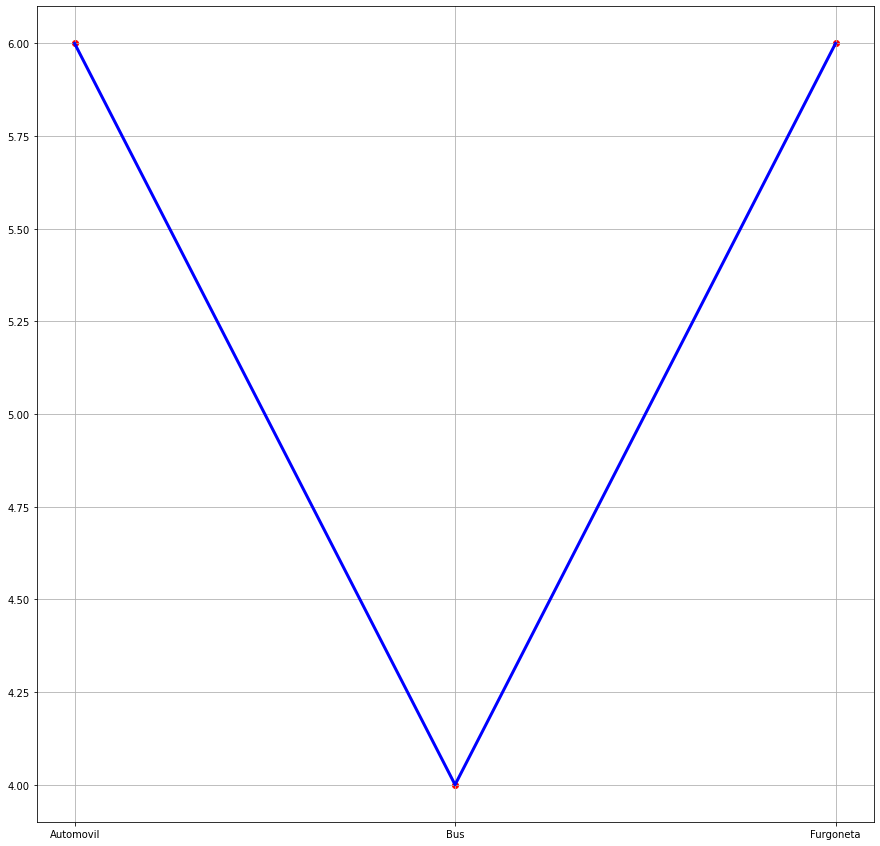

In [ ]:
datos = sorted(tiempo.items())
x, y = zip(*datos)
plt.plot(x,y,linewidth=3, color="blue")
plt.gcf().set_size_inches(15, 15)
plt.scatter(x,y,color='red')
plt.grid(True)
plt.show()

# 4 MAQUINAS #

In [ ]:
# Maximo de vehiculos que puede recibir el negocio
MAX_VEHICULOS = 57 
# Total de maquinas de lavado con que cuenta el negocio
NUM_MAQUINAS = 4
#Tiempo de traslado de vehiculos
TRASLADO= [4,1,2]
# Tiempo que tarda en lavarse un vehiculo (minutos)
#Bus: 20min, Automóvil: 7min, Furgoneta: 12min
TIEMPO_LAVADO =[20,7,12] #7 
# Intervalo de tiempo en que llegan vehiculos (minutos)
# Bus: 4min, Automóvil: 1 min, Furgoneta: 2 min.
INTERVALO_LLEGADA = 10
# Tiempo de simulación
TIEMPO_SIMULACION = 100

tiempo= {}

In [ ]:
class Lavanderia(object):
    
    def __init__(self, environment, num_maquinas,tiempo_bus,tiempo_automovil,
                 tiempo_furgoneta,traslado_bus,traslado_automovil,traslado_furgoneta):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.maquinas = simpy.Resource(environment, num_maquinas)
        # Variable para el tiempo de lavado
        self.tiempo_bus = tiempo_bus
        self.tiempo_automovil = tiempo_automovil
        self.tiempo_furgoneta = tiempo_furgoneta
        self.traslado_bus = traslado_bus
        self.traslado_automovil = traslado_automovil
        self.traslado_furgoneta = traslado_furgoneta
        
    def lavar_vehiculo(self, vehiculo):
        automotor=vehiculo.split('-')
        if(automotor[0] == 'Bus'):
            yield self.env.timeout(TRASLADO[0])
        if(automotor[0] == 'Automovil'):
            yield self.env.timeout(TRASLADO[1])
        if(automotor[0] == 'Furgoneta'):
            yield self.env.timeout(TRASLADO[2])
        #Solo agregamos al diccionario al momento que termina de lavar el vehiculo.
        k=automotor[0]
        if k in tiempo:
            tiempo[k]=tiempo[k]+1
        else:
            tiempo[k]=1
            
        # Simulamos que se ha limpiado parte (%) de la suciedad del vehiculo
        # Para el % generamos un entero entre 30 y 90
        print('Removido  {%d%%} suciedad vehiculo => %s ' %(random.randint(30,90), vehiculo))
        
    def trasladar_vehiculo(self, vehiculo):
        automotor=vehiculo.split('-')
        if(automotor[0] == 'Bus'):
            yield self.env.timeout(TRASLADO[0])
        if(automotor[0] == 'Automovil'):
            yield self.env.timeout(TRASLADO[1])
        if(automotor[0] == 'Furgoneta'):
            yield self.env.timeout(TRASLADO[2])
       
    


In [ ]:
def llegada_vehiculo(env, nombre, lavanderia):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el vehiculo con el nombre pasado como parametro
    print('Llega vehiculo: %s a la hora %.2f.' % (nombre, env.now))
    
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la maquina de lavado
    with lavanderia.maquinas.request() as maquina:
        # Ocupamos la maquina de lavado
        yield maquina
        #Indicamos que el vehiculo se esta trasladando para ser lavado
        print('Se traslada vehiculo: %s a la hora %.2f.' % (nombre,env.now))
        #Procesamos el traslado del vehiculo
        yield env.process(lavanderia.trasladar_vehiculo(nombre))
        # Indicamos que vehiculo entra a la lavanderia
        print('Entra vehiculo a lavarse: %s a la hora %.2f.' % (nombre, env.now))
        # Procesamos la operacion de lavado
        yield env.process(lavanderia.lavar_vehiculo(nombre))
        # Una vez que termina la llamada con 'yield', se indica que se ha lavado el vehiculo
        print('Vehiculo [%s] lavado a las %.2f.' % (nombre, env.now))  
        

In [ ]:
def ejecutar_simulacion(env, num_maquinas, tiempo_bus,tiempo_automovil,
                        tiempo_furgoneta,traslado_bus,traslado_automovil,
                        traslado_furgoneta, intervalo):
    lavanderia=Lavanderia(env, num_maquinas, tiempo_bus,tiempo_automovil,
                          tiempo_furgoneta,traslado_bus,traslado_automovil,
                          traslado_furgoneta)
    # Creamos 5 llegadas de vehiculos iniciales
    for i in range(2):
        env.process(llegada_vehiculo(env, 'Bus-%d'%(i+1),lavanderia))
        env.process(llegada_vehiculo(env, 'Automovil-%d'%(i+1),lavanderia))
        env.process(llegada_vehiculo(env, 'Furgoneta-%d'%(i+1),lavanderia))
        
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(random.randint(intervalo-3, intervalo+3))
        i+=1
        # Mientras se lavan los vehiculos generamos mas vehiculos
        rnd = random.randint(1,100)
        if rnd <= 20: # Bus 20%, Furgoneta 30% y Automovil 50%
            env.process(llegada_vehiculo(env,'Bus-%d'%(i+1),lavanderia))
        elif rnd <= 50:
            env.process(llegada_vehiculo(env,'Furgoneta-%d'%(i+1),lavanderia))
        else:
            env.process(llegada_vehiculo(env,'Automovil-%d'%(i+1),lavanderia))

In [ ]:
print('Lavanderia UPS')
# Inicializamos la semilla aleatoria
random.seed(77)
# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_MAQUINAS, TIEMPO_LAVADO[0],TIEMPO_LAVADO[1],\
                                TIEMPO_LAVADO[2]\
                                ,TRASLADO[0],TRASLADO[1],TRASLADO[2]
                                , INTERVALO_LLEGADA))
# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

Lavanderia UPS
Llega vehiculo: Bus-1 a la hora 0.00.
Llega vehiculo: Automovil-1 a la hora 0.00.
Llega vehiculo: Furgoneta-1 a la hora 0.00.
Llega vehiculo: Bus-2 a la hora 0.00.
Llega vehiculo: Automovil-2 a la hora 0.00.
Llega vehiculo: Furgoneta-2 a la hora 0.00.
Se traslada vehiculo: Bus-1 a la hora 0.00.
Se traslada vehiculo: Automovil-1 a la hora 0.00.
Se traslada vehiculo: Furgoneta-1 a la hora 0.00.
Se traslada vehiculo: Bus-2 a la hora 0.00.
Entra vehiculo a lavarse: Automovil-1 a la hora 1.00.
Removido  {46%} suciedad vehiculo => Automovil-1 
Entra vehiculo a lavarse: Furgoneta-1 a la hora 2.00.
Vehiculo [Automovil-1] lavado a las 2.00.
Se traslada vehiculo: Automovil-2 a la hora 2.00.
Entra vehiculo a lavarse: Automovil-2 a la hora 3.00.
Removido  {50%} suciedad vehiculo => Furgoneta-1 
Removido  {42%} suciedad vehiculo => Automovil-2 
Entra vehiculo a lavarse: Bus-1 a la hora 4.00.
Entra vehiculo a lavarse: Bus-2 a la hora 4.00.
Vehiculo [Furgoneta-1] lavado a las 4.00.
Veh

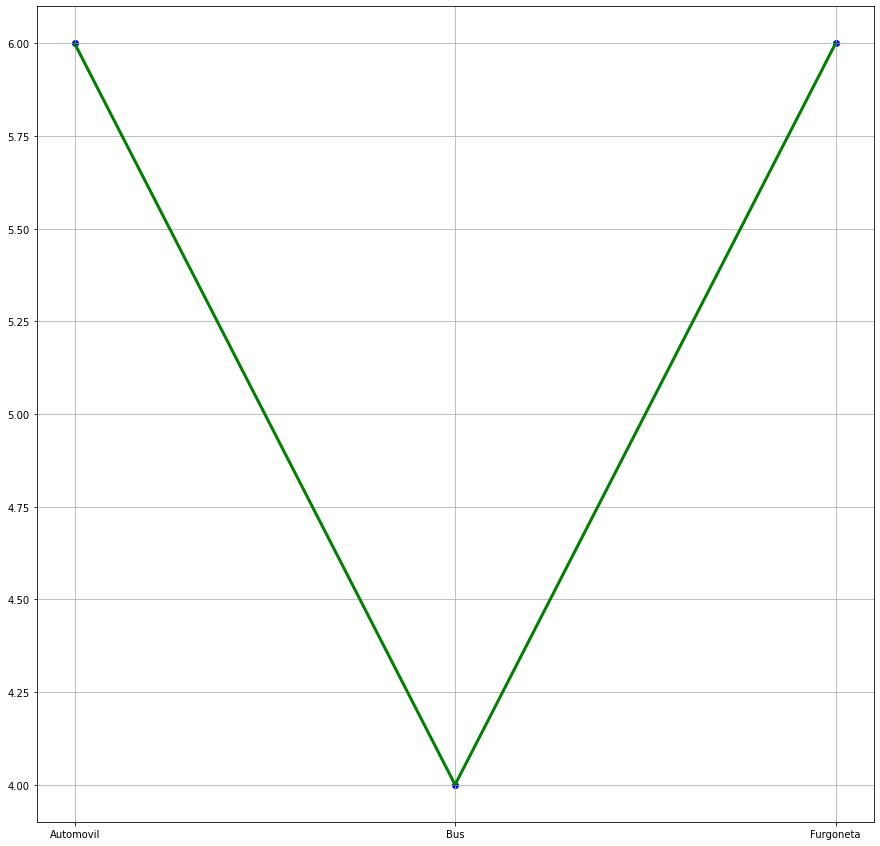

In [ ]:
datos2 = sorted(tiempo.items())
x, y = zip(*datos2)
plt.plot(x,y,linewidth=3, color="green")
plt.gcf().set_size_inches(15, 15)
plt.scatter(x,y,color='blue')
plt.grid(True)
plt.show()